# Movie Genre Prediction by Poster
The goal of this notebook is to try to predict a movie's genre by looking at the poster it has.
To achieve this goal I will:
1. Use [The Movies Dataset](https://www.kaggle.com/rounakbanik/the-movies-dataset) to get 45k movie titles.
2. Use the [omdb_api](http://www.omdbapi.com/) to get the posters for the movies and store them localy.
3. Use Tensorflow and Keras to create a ConvNet that will classify the images.

## Project Structure
1. Data loading, acquisition and cleaning
2. Model creation.
3. Model evaluation.
4. Prediction.

In [1]:
# Library Loading
import json
from urllib.parse import urlencode
import requests
import pandas as pd
import os
import numpy as np
from shutil import move
import matplotlib.pyplot as plt


# Loading the 
OMDB_KEY = json.loads(open('apikeys/apikey.json').read())['key']

## 1. Data loading, acquisition and cleaning

### 1.1 Loading 'The Movies' dataset.

In [2]:
the_movies = pd.read_csv('./datasets/The_Movies/movies_metadata.csv')

/home/fury/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3049: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
the_movies.head()

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",...,1995-10-30,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0
1,False,NaN,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,...,1995-12-15,262797249.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0
2,False,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",0,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",NaN,15602,tt0113228,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,...,1995-12-22,0.0,101.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,False,6.5,92.0
3,False,NaN,16000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,31357,tt0114885,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",...,1995-12-22,81452156.0,127.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Friends are the people who let you be yourself...,Waiting to Exhale,False,6.1,34.0
4,False,"{'id': 96871, 'name': 'Father of the Bride Col...",0,"[{'id': 35, 'name': 'Comedy'}]",NaN,11862,tt0113041,en,Father of the Bride Part II,Just when George Banks has recovered from his ...,...,1995-02-10,76578911.0,106.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Just When His World Is Back To Normal... He's ...,Father of the Bride Part II,False,5.7,173.0


### 1.2 Defining the API functions

In [4]:
def get_movie(imdbid):
    '''Gets the movie by imdb id and returns json with the title, genre and imdb id.
       Input args:
       - imdbid: the imdb id of the character
       Returns:
       - If the API responds succesfully return the genres, otherwise return NA
    - 
    '''
    url = 'http://www.omdbapi.com/?apikey=' + OMDB_KEY + '&i=' + str(imdbid)
    r = requests.get(url)
    if r.status_code == 200:
        movie_json = r.json()
        return movie_json['Genre']
    else:
        return 'NA'

def get_poster(imdb_id, path, genre, dataset_type, image_heigth, item_id):
    '''Gets the movie poster as a jpg and saves it to the path.
       Input args:
       - imbd_id: the imdb id of the movie,
       - path: where the dataset will be stored,
       - genre: the genre of the movie,
       - dataset_type: whether we are creating the training or testing,
       - image_height: the height of the poster - api query
       - item_id: identifier to attach to the filename
       Returns:
       - None
    '''
    # construct the requests url
    url = 'http://img.omdbapi.com/?apikey=' + OMDB_KEY + '&i=' + str(imdb_id) + '&h=' + str(image_heigth)
    # create the dir where we store the posters based on the genre and the dataset type
    path = os.path.join(os.getcwd(), path, dataset_type, genre + '/')
    # check if the folder is already_created
    if not os.path.exists(path):
        os.makedirs(path)
    r = requests.get(url)
    filename = os.path.join(os.getcwd(), path, genre + '.' + str(item_id) + '.jpg')
    if r.status_code == 200:
        with open(filename, 'wb') as w:
            w.write(r.content)

### 1.3 Downloading the movie posters.

As a movie can have multiple genres I will make an assumption here - if a genre is listed first - that will be the genre of the movie. Let's create a function that will get only the main genre of the movie from the dataset. If it doesn't find one - download it straight from imdb.

In [5]:
import ast

def get_main_genre(dataset_genre, imdb_id):
    '''
        Gets the main genre of the movie. If there is none listed - pull one directly from imdb.
        Input args:
        - genre_row: the dataset value of the genres for the movie,
        - imdb_id: the imdb_id of the movie
        Returns:
        - main_genre: the main genre of the movie 
    '''
    dataset_genre = ast.literal_eval(dataset_genre)
    if len(dataset_genre) == 0:
        try: 
            main_genre = get_movie(imdb_id).replace(' ', '').split(',')[0]
        except KeyError:
            main_genre = 'NA'
    else:
        main_genre = dataset_genre[0]['name']
        if main_genre == 'N/A':
            main_genre = 'NA'
    return main_genre

In [6]:
# DANGER: Slow Code!
the_movies['main_genre'] = the_movies.apply(lambda x: get_main_genre(x['genres'], x['imdb_id']), axis=1)

In [7]:
the_movies['main_genre'].unique().shape 

(31,)

In [8]:
# quick fix for N/As
the_movies[the_movies['main_genre'] == 'N/A'] = 'NA'

All in all we got 30 classes. Let's create the train - test split now, as we will need it for movie poster download.

In [191]:
from sklearn.model_selection import train_test_split

movies_train, movies_test = train_test_split(the_movies, test_size=0.3, random_state=0)

Finally downloading the movies

In [ ]:
# downloading the posters for the train set
for idx, row in movies_train.iterrows():
    # get_poster(imdb_id, path, genre, dateset_type, image_heigth, item_id):
    get_poster(row['imdb_id'], 'datasets/The_Movies/posters', row['main_genre'], 'train', 600, idx)
# downloading the posters for the test set
for idx, row in movies_test.iterrows():
    get_poster(row['imdb_id'], 'datasets/The_Movies/posters', row['main_genre'], 'test', 600, idx)

The code above has been moved to a script so it can stay overnight and download all of the movies' posters. 
Since that has been done lets move on to what genres we have actually downloaded.

In [36]:
os.listdir('./datasets/The_Movies/posters/train')

['Drama',
 'Documentary',
 'Foreign',
 'Short',
 'Horror',
 'Science Fiction',
 'Action',
 'Comedy',
 'Music',
 'Biography',
 'War',
 'Thriller',
 'Fantasy',
 'Adventure',
 'Romance',
 'Musical',
 'Carousel Productions',
 'Adult',
 'Mystery',
 'Western',
 'History',
 'TV Movie',
 'Crime',
 'Animation',
 'Family']

From the list of downloaded genres above we can see somethings we can edit/remove. For example 
- Sci-Fi and Science Fiction are the same thing so both dirs can be merged to a common category 'Science Fiction'
- 'Aniplex', 'Odyssey Media' and 'Carousel Productions' are actually names of companies. Will see how much samples they contribute and if it is not significant (~100 or more)they will be deleted.
- NA - The same treatment - check the number of samples and delete them.

#### Results
- Sci-Fi - it seems that there are only 5 posters in Sci-Fi - thus I can merge it into 'Science Fiction'
- 'Odyssey Media' and 'Carousel Productions' and 'NA' contained no information whatsover.
- 'Removed also 'Adult' as it contained no posters.

#### Aditional Checks performed
- Whether both dirs contain the same genres and the same number of genres.

### 1.4 Creating the validation set

In [5]:
def get_total_posters(dataset, location):
    '''Utility function to get the number of items per dataset type'''
    num_items = 0
    for item in os.listdir(location):
        num_posters =len(os.listdir(os.path.join(location, item)))
        num_items += num_posters

    print("%s: %i" % (dataset, num_items))

In [20]:
def move_data_to_validation(perc, location, target_location):
    '''
    Move a certain percentage of the target dataset to a new location.
    The percentage is drawn from each genre.
    '''
    for genre in os.listdir(location):
        dir_contents = os.listdir(os.path.join(location, genre))
        dir_len = len(dir_contents)
        num_items_to_take = int(np.ceil(perc * dir_len / 100))
        # Randomize the draw with a integeres drawn from descrete uniform
        items_idx_array = np.random.choice(dir_len, num_items_to_take, replace = False)    
        
        for idx in items_idx_array:
            src = os.path.join(location, genre, dir_contents[idx])
            dst_dir = os.path.join(target_location, genre)
            if not os.path.exists(dst_dir): # make sure that the path exists
                os.makedirs(dst_dir)
            move(src, os.path.join(dst_dir, dir_contents[idx]))
            
    print('Done!') # just because

In [24]:
# lets move data
validation_location = './datasets/The_Movies/posters/validation'
move_data_to_validation(20, train_location, validation_location)

Done!


In [3]:
train_location = './datasets/The_Movies/posters/train'
test_location = './datasets/The_Movies/posters/test'
validation_location = './datasets/The_Movies/posters/validation'

In [6]:
get_total_posters('train', train_location)
get_total_posters('test', test_location)
get_total_posters('validation', validation_location)

train: 26611
test: 8328
validation: 6665


## 2. Model creation.

### 2.1 Importing the neccesarry libraries.

In [7]:
# Importing the libraries
import keras
from keras import backend as K
from keras import regularizers
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Dense, Dropout, Flatten
from keras.models import load_model
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from keras.metrics import categorical_accuracy

Using TensorFlow backend.


### 2.2  Loading the data.
With the help of Keras that should be quite straightforward. The ImageDataGenerator can be used to load the data and get the labels simultaneously in a neat 2D one-hot encoded format. In addition it allows us to generate additional train/validation/test data.

On the other hand my workflow is made in such a way that I create the model here and use a machine with a GPU to train it and load the the trained model to evaluate it.

In [8]:
train_datagen = ImageDataGenerator(rescale = 1./255)
test_datagen = ImageDataGenerator(rescale = 1./255)
validation_datagen = ImageDataGenerator(rescale = 1./255)

# The generators
train_generator = train_datagen.flow_from_directory(
    train_location,
    target_size = (224, 224),
    color_mode = 'rgb',
    batch_size = 8,
    class_mode = 'categorical'
)

test_generator = test_datagen.flow_from_directory(
    test_location,
    target_size = (224, 224),
    color_mode = 'rgb',
    batch_size = 8,
    class_mode = 'categorical'
)

validation_generator = validation_datagen.flow_from_directory(
    validation_location,
    target_size = (224, 224),
    color_mode = 'rgb',
    batch_size = 8,
    class_mode = 'categorical'
)

Found 26611 images belonging to 23 classes.
Found 8328 images belonging to 23 classes.
Found 6665 images belonging to 23 classes.


[0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


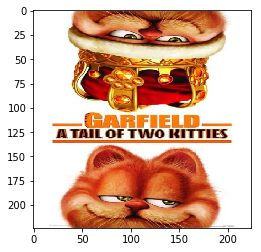

In [9]:
# Show one of the images
x, y = validation_generator.next()
for i in range(0,1):
    print(y[i])
    image = x[i]
    plt.imshow(image)
    plt.show()

#### 2.2.1 Augmented images generators
The idea was to capture the logic of the images - as they are - to try to get an idea if there is a pattern in the images - their colors or shapes. Let's create an image generators where they actually augment the images.

In [10]:
train_aug_datagen = ImageDataGenerator(
    rescale = 1./255,
    shear_range = 0.2,
    zoom_range = 0.2,
    horizontal_flip = True)

test_aug_datagen = ImageDataGenerator(
    rescale = 1./255,
    shear_range = 0.2,
    zoom_range = 0.2,
    horizontal_flip = True)

validation_aug_datagen = ImageDataGenerator(
    rescale = 1./255,
    shear_range = 0.2,
    zoom_range = 0.2,
    horizontal_flip = True)

# The generators
train_aug_generator = train_aug_datagen.flow_from_directory(
    train_location,
    target_size = (224, 224),
    color_mode = 'rgb',
    batch_size = 8,
    class_mode = 'categorical'
)

test_aug_generator = test_aug_datagen.flow_from_directory(
    test_location,
    target_size = (224, 224),
    color_mode = 'rgb',
    batch_size = 2,
    class_mode = 'categorical'
)

validation_aug_generator = validation_aug_datagen.flow_from_directory(
    validation_location,
    target_size = (224, 224),
    color_mode = 'rgb',
    batch_size = 8,
    class_mode = 'categorical'
)

Found 26611 images belonging to 23 classes.
Found 8328 images belonging to 23 classes.
Found 6665 images belonging to 23 classes.


### 2.3 Model Building
There are essentially two routes we can take - either a pre-trained winner of ImageNet like AlexNet, GoogleNet, VGG. A pre-trained model may give better results, however for the fun of it I will try to create a custom architecture.

Let's try a simple architecture at first and then we can improve upon it.

Update after *[1st Run]* - It seems that the model fails to generalize and underfits with only 27% of accuracy. 

Architectures:  
*[1st Run]*
1. 4 convolutional layers, 3x3 with the default stride of 1, separated by two MaxPools of 2x2 layers encoding layers
2. 3 Fully connected layers - all multiples of the total number of genres.
3. The final layer - 'Softmax' for multiclass classification.


*[2nd Run]*
1. Add an additional layer of filters between each *maxpool* with the idea to get more features. Also add an additional fully connected model.

*[3rd Run]*
1. Increased the image size with the same window and stride - the goal is to get more data in.
2. Removed one dense layer as it was no longer neccessary.

*[4th Run]*
1. As the model overfits severly let's try to add dropouts between each step - first 0.25 between the filters and 0.5 between the fully connected model.

*[5th Run]*  
1. Using VGG instead.

*[6th Run]*
1. Using image data generation to create additional images. Both my model and VGG will be trained on it.

*[7th Run]*
1. Making the dense layers trainable, while leaving the convolutional ones intact.

#### My Model

In [10]:
# My Model
classifier = Sequential()
classifier.add(Conv2D(64, (3,3), input_shape = (224, 224, 3), activation = 'relu'))
classifier.add(Conv2D(64, (3,3), activation = 'relu'))
classifier.add(MaxPooling2D(pool_size = (2,2)))
classifier.add(Dropout(0.25))
classifier.add(Conv2D(128, (3,3), activation = 'relu'))
classifier.add(Conv2D(128, (3,3), activation = 'relu'))
classifier.add(MaxPooling2D(pool_size = (2,2)))
classifier.add(Dropout(0.25))
classifier.add(Flatten())
classifier.add(Dense(units = 128, activation = 'relu'))
classifier.add(Dropout(0.5))
classifier.add(Dense(units = 64, activation = 'relu'))
classifier.add(Dropout(0.5))
classifier.add(Dense(units = 23, activation = 'softmax'))

In [11]:
classifier.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 222, 222, 64)      1792      
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 220, 220, 64)      36928     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 110, 110, 64)      0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 110, 110, 64)      0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 108, 108, 128)     73856     
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 106, 106, 128)     147584    
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 53, 53, 128)       0         
__________

#### VGG16

In [10]:
vgg16_model = keras.applications.vgg16.VGG16()

Instructions for updating:
Colocations handled automatically by placer.


In [11]:
vgg16_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

Since the model is not sequential I copy its contents to a new sequential one. Also it can be seen that the prediction layer is expecting 1000 outputs, which I need to change to just 23 - our number of classes.

In addition my goal is to keep the weights of VGG16 the same, thus I will make the weights untrainable, except for the last 3 dense layers.

In [12]:
classifier_vgg16 = Sequential()
for layer in vgg16_model.layers[:-3]:
    classifier_vgg16.add(layer)

In [13]:
# Make VGG16 keep all of its weights
for layer in classifier_vgg16.layers:
    layer.trainable = False

# add the last layer
classifier_vgg16.add(Dense(4096, activation = 'relu'))
classifier_vgg16.add(Dense(4096, activation = 'relu'))
classifier_vgg16.add(Dense(23, activation = 'softmax'))

In [14]:
classifier_vgg16.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 56, 56, 256)       295168    
__________

#### DenseNet
The approach would be different from VGG16 - just train the final layer.

In [16]:
dense_model = keras.applications.densenet.DenseNet121()

In [19]:
# dense_model.summary() - won't do a summary - too long
# Make DenseNet keep all of its weights
classifier_dense = Sequential()
for layer in dense_model.layers[:-1]:
    classifier_dense.add(layer)
    
for layer in classifier_dense.layers:
    layer.trainable = False

# add the last layer
classifier_dense.add(Dense(23, activation = 'softmax'))

#### Choosing an optimizer: [Why is ADAM the optimizer?](https://arxiv.org/pdf/1609.04747.pdf)

In [15]:
# Compile the model
# classifier.compile(Adam(lr = .001),
#                    loss = 'binary_crossentropy',
#                    metrics = [categorical_accuracy])
# Compile VGG16ta
classifier_vgg16.compile(Adam(lr = .001), 
                   loss = 'binary_crossentropy', 
                   metrics = ['accuracy'])

In [19]:
# classifier.save('./movie_genre_prediction/models/clf_untrained.model')
classifier_vgg16.save('./movie_genre_prediction/models/clf_vgg16_untrained.model')

In [17]:
# My Model
# classifier fit example
classifier.fit_generator(train_generator,
                         steps_per_epoch = train_generator.n // train_generator.batch_size, # Example steps, real: training_generator.n // train_generator.batch_size
                         epochs = 10,
                         validation_data = validation_generator,
                         validation_steps = validation_generator.n // validation_generator.batch_size) # Example steps, real: validation_generator.n // validation_generator.batch_size

Epoch 1/10
3425/3425 [==============================] - 519s 152ms/step - loss: 0.1529 - categorical_accuracy: 0.2439 - val_loss: 0.1479 - val_categorical_accuracy: 0.2781
Epoch 2/10
3425/3425 [==============================] - 468s 137ms/step - loss: 0.1457 - categorical_accuracy: 0.2666 - val_loss: 0.1408 - val_categorical_accuracy: 0.2788
Epoch 3/10
3425/3425 [==============================] - 468s 137ms/step - loss: 0.1432 - categorical_accuracy: 0.2844 - val_loss: 0.1401 - val_categorical_accuracy: 0.3119
Epoch 4/10
3425/3425 [==============================] - 471s 138ms/step - loss: 0.1407 - categorical_accuracy: 0.2973 - val_loss: 0.1401 - val_categorical_accuracy: 0.2954
Epoch 5/10
3425/3425 [==============================] - 471s 138ms/step - loss: 0.1375 - categorical_accuracy: 0.3096 - val_loss: 0.1386 - val_categorical_accuracy: 0.3230
Epoch 6/10
3425/3425 [==============================] - 470s 137ms/step - loss: 0.1332 - categorical_accuracy: 0.3310 - val_loss: 0.1389 - v

In [16]:
# classifier fit example
classifier_vgg16.fit_generator(train_aug_generator,
                         steps_per_epoch = train_aug_generator.n // train_aug_generator.batch_size,
                         epochs = 0,
                         validation_data = validation_aug_generator,
                         validation_steps = validation_aug_generator.n // validation_aug_generator.batch_size)

Instructions for updating:
Use tf.cast instead.


## 3. Model Evaluation

#### Results
I will record all of the results here, in order to not make this notebook endless.

* [1st run] (2xConv2D(32, (3x3); maxpool, 2xConv2D(64, (3x3)), maxpool, 3 full connected layers) - *Train*: 2.32 loss; 0.26 accuracy; *Test*: 2.31 loss; 0.27 accuracy;
* [2nd run] (3xConv2D(32, (3x3); maxpool, 3xConv2D(64, (3x3)), maxpool, 4 full connected layers) - *Train*: 2.30 loss; 0.28 accuracy; *Test*: 2.31 loss; 0.27 accuracy;
* [3nd run] (3xConv2D(32, (3x3); maxpool, 3xConv2D(64, (3x3)), maxpool, 3 full connected layers) - *Train*: 0.04 loss; 0.9919 accuracy; *Test*: 11.02 loss; 0.19 accuracy;
* [4nd run] (3xConv2D(32, (3x3); maxpool, Dropout(0.25), 3xConv2D(64, (3x3)), maxpool, Dropout(0.25), 3 full connected layers Dropout(0.5) inbetween) - *Train*: 2.334 loss; 0.278 accuracy; *Test*: 2.333 loss; 0.276 accuracy;
* [5th run] (VGG16 pre-trained) - *Train*: 2.896 loss; 0.278 accuracy; *Test*: 2.88 loss; 0.276 accuracy;
* [---Models Comparison---] 
    * My model: *Train*: 1.544 loss; 0.514 accuracy; *Test*: 2.757 loss; 0.298 accuracy;
    * VGG16 model: *Train*: 2.082 loss; 0.360 accuracy; *Test*: 2.174 loss; 0.340 accuracy;

* [6th run] - With augomented data.
    * My model: *Train*: 0.115 loss; 0.301 accuracy; *Test*: 0.134 loss; 0.298 accuracy;
    * VGG16 model: *Train*: 0.13 loss; 0.340 accuracy; *Test*: 0.131 loss; 0.348 accuracy;



In [17]:
# Load models
classifier_vgg16.load_weights('./movie_genre_prediction/models/clf_trained.model')
# classifier_vgg16_trained = load_model('./movie_genre_prediction/models/clf_trained_vgg.model')

**My Model Evaluation**

In [19]:
classifier.evaluate_generator(test_aug_generator, steps = test_aug_generator.n, max_queue_size=2, verbose=1)

8362/8362 [==============================] - 260s 31ms/step


[0.15028438562381619, 0.27086821334608946]

**VGG Model Evaluation**

In [18]:
classifier_vgg16.evaluate_generator(test_aug_generator, steps = test_aug_generator.n, max_queue_size=2, verbose=1)

8328/8328 [==============================] - 280s 34ms/step


[1.1053722158784194, 0.9310445806135018]

## 4. Prediction

### 4.1 Generating a sample

In [19]:
x, y = test_aug_generator.next()

In [20]:
y[0]

array([0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0.], dtype=float32)

In [23]:
clf_prediction = np.around(classifier_vgg16.predict(x)[0], decimals = 3)
clf_vgg16_prediction = np.around(classifier_vgg16.predict(x)[0], decimals = 3)

A bit of laziness at the end - just assigned my model to the vgg16 results.

### 4.2 Comparison between predicted and actual
Since both classifiers return probabilities of the values being a certain genre to get the actual genre, The indices should be compared.

In [24]:
print("Actual: %i; My Model: %i; VGG16: %i"  % (np.argmax(y[0]), np.argmax(clf_prediction), np.argmax(clf_vgg16_prediction)))

Actual: 4; My Model: 4; VGG16: 4


## 5. Conclusion (for now)...
VGG was able to reach 93% of accuracy when evaluated on the test set.

Future work:
1. Implement a DenseNet and compare the results.
2. Implement a ResNet and compare the results.